In [1]:
!pip install librosa transformers torch pandas numpy scikit-learn tqdm

In [2]:
import os
import glob
import numpy as np
import pandas as pd
import librosa
from transformers import AutoTokenizer, AutoModel
import torch
from tqdm import tqdm

In [3]:
# Load BERT tokenizer and model on CPU
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
model = AutoModel.from_pretrained("bert-base-uncased")

In [4]:
def extract_mfcc(audio_path):
    # Extract average MFCC vector from wav file
    y, sr = librosa.load(audio_path, sr=16000)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    return np.mean(mfcc, axis=1)  # (13,)

def extract_text_embedding(text):
    # Extract BERT embedding from text ([CLS] token)
    if not text.strip():
        text = "empty"
    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=128)
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.last_hidden_state[0][0].numpy()  # (768,)


In [5]:
# Adjust your own paths here
base_dirs = [('C:/Users/user/ParkinsonMultimodal/10sec_Healthy', 0), ('C:/Users/user/ParkinsonMultimodal/10sec_Parkinson', 1)]
# 0 = healthy, 1 = parkinson

In [6]:
feature_vectors = []
labels = []

for folder, label in base_dirs:
    wav_paths = glob.glob(os.path.join(folder, "*.wav"))
    print(f"{folder}: {len(wav_paths)} wav files found.")
    for wav_path in tqdm(wav_paths):
        # 1. Audio feature
        mfcc_vec = extract_mfcc(wav_path)
        # 2. Text feature
        txt_path = wav_path.replace(".wav", ".txt")
        try:
            with open(txt_path, encoding="utf-8") as f:
                text = f.read().strip()
        except FileNotFoundError:
            print(f"Transcript not found: {txt_path}")
            text = "empty"
        bert_vec = extract_text_embedding(text)
        # 3. Combine features
        multi_vec = np.concatenate([mfcc_vec, bert_vec])
        feature_vectors.append(multi_vec)
        labels.append(label)

feature_vectors = np.array(feature_vectors)
labels = np.array(labels)

print("Feature matrix shape:", feature_vectors.shape)  # (N, 781)
print("Labels shape:", labels.shape)                   # (N,)


C:/Users/user/ParkinsonMultimodal/10sec_Healthy: 635 wav files found.


  0%|          | 0/635 [00:00<?, ?it/s]C:\Users\user\anaconda3\Lib\site-packages\paramiko\pkey.py:82: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "cipher": algorithms.TripleDES,
C:\Users\user\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.Blowfish and will be removed from this module in 45.0.0.
  "class": algorithms.Blowfish,
C:\Users\user\anaconda3\Lib\site-packages\paramiko\transport.py:243: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "class": algorithms.TripleDES,
100%|██████████| 635/635 [00:42<00:00, 15.02it/s]


C:/Users/user/ParkinsonMultimodal/10sec_Parkinson: 631 wav files found.


100%|██████████| 631/631 [00:38<00:00, 16.54it/s]

Feature matrix shape: (1266, 781)
Labels shape: (1266,)


In [7]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

# Split data into train and test
X_train, X_test, y_train, y_test = train_test_split(
    feature_vectors, labels, test_size=0.2, random_state=42
)

# Train the model
clf = RandomForestClassifier()
clf.fit(X_train, y_train)

# Predict and print results
y_pred = clf.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Accuracy: 0.8464566929133859
              precision    recall  f1-score   support

           0       0.87      0.84      0.86       137
           1       0.82      0.85      0.84       117

    accuracy                           0.85       254
   macro avg       0.85      0.85      0.85       254
weighted avg       0.85      0.85      0.85       254



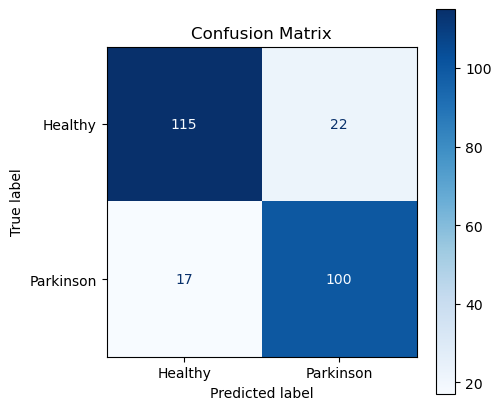

In [8]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Create and display confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Healthy", "Parkinson"])
fig, ax = plt.subplots(figsize=(5, 5))
disp.plot(ax=ax, cmap='Blues')
plt.title("Confusion Matrix")
plt.show()


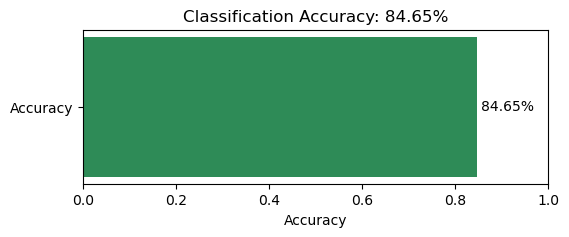

In [9]:
import matplotlib.pyplot as plt

# Accuracy bar visualization
acc = accuracy_score(y_test, y_pred)
plt.figure(figsize=(6,2))
plt.barh(['Accuracy'], [acc], color='seagreen')
plt.xlim(0, 1)
plt.xlabel("Accuracy")
plt.title(f"Classification Accuracy: {acc:.2%}")
for i, v in enumerate([acc]):
    plt.text(v + 0.01, i, f"{v:.2%}", va='center')
plt.show()


In [10]:
from sklearn.metrics import classification_report
import pandas as pd

# Get classification report as dict, convert to DataFrame
report_dict = classification_report(y_test, y_pred, target_names=["Healthy", "Parkinson"], output_dict=True)
report_df = pd.DataFrame(report_dict).transpose()

# Only keep the main classes (not 'accuracy', 'macro avg', etc.)
display(report_df.loc[["Healthy", "Parkinson"]].style.background_gradient(axis=1, cmap='Blues').format("{:.2f}"))


,precision,recall,f1-score,support
Healthy,0.87,0.84,0.86,137.00
Parkinson,0.82,0.85,0.84,117.00


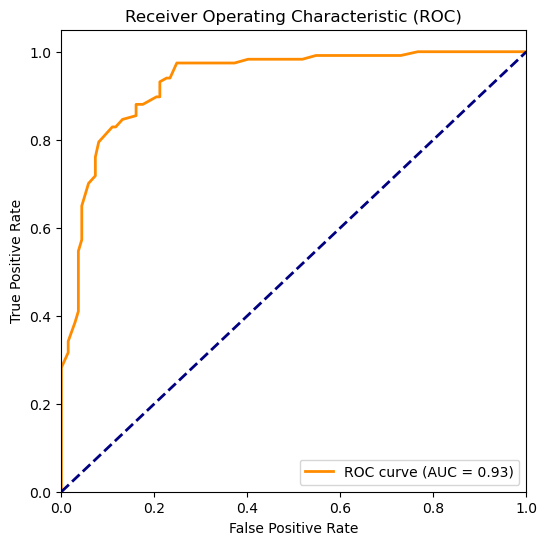

In [11]:
from sklearn.metrics import roc_curve, auc

# Only for binary classification!
y_score = clf.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

In [12]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Split features and numeric labels for regression
X_train, X_test, y_train, y_test = train_test_split(
    feature_vectors, labels, test_size=0.2, random_state=42
)

# Train a random forest regressor
reg = RandomForestRegressor()
reg.fit(X_train, y_train)

# Predict regression scores on test set
y_pred = reg.predict(X_test)


In [13]:
import matplotlib.pyplot as plt
import pandas as pd

# Calculate common regression metrics
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Show metrics in a DataFrame
metrics_df = pd.DataFrame({
    "R^2 Score": [r2],
    "MAE": [mae],
    "MSE": [mse]
})
display(metrics_df.style.background_gradient(axis=1, cmap='Greens').format("{:.3f}"))

,R^2 Score,MAE,MSE
0,0.566,0.261,0.108


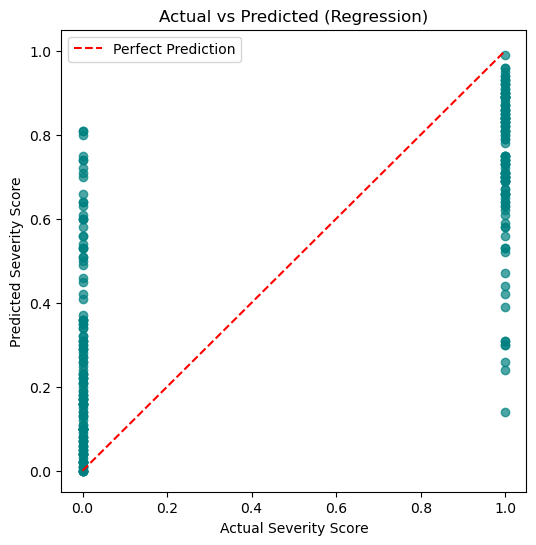

In [14]:
# Scatter plot: True vs. Predicted scores
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, color='teal', alpha=0.7)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Perfect Prediction')
plt.xlabel('Actual Severity Score')
plt.ylabel('Predicted Severity Score')
plt.title('Actual vs Predicted (Regression)')
plt.legend()
plt.show()